<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
!pip -q install torchinfo
from torchinfo import summary

import numpy as np
from torch.autograd import Variable
# from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from IPython.display import clear_output
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from tqdm import tqdm
import copy
from matplotlib.gridspec import GridSpec
from PIL import Image


%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, downloading...")
        os.system("wget -q http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget -q http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    file_attrs = df[["photo_path","person","imagenum"]].copy()
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs, file_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs, file_attrs = fetch_dataset()

images not found, downloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

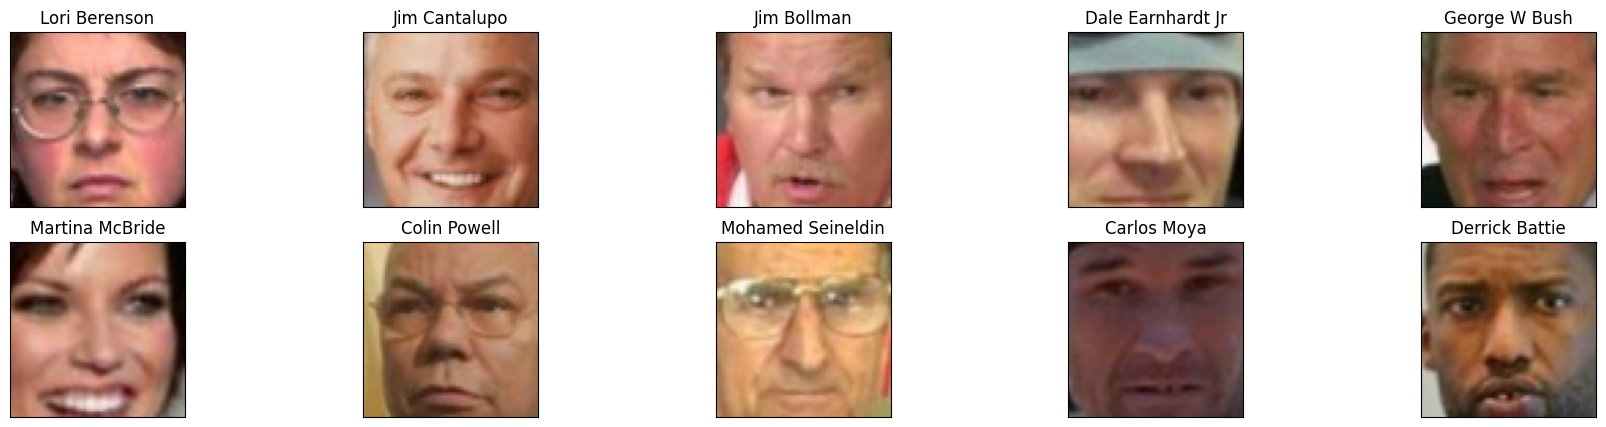

In [4]:
# train, val spllit

train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, 
                                                                    test_size=0.2, 
                                                                    shuffle=False, 
                                                                    random_state=1337)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(22, 5), sharey=True, sharex=True)

for fig_x in ax.flatten():
    idx = np.random.randint(0, train_photos.shape[0])
    fig_x.imshow(train_photos[idx])
    plt.xticks([])
    plt.yticks([])
    fig_x.set_title(file_attrs['person'].iloc[idx])
    plt.grid(True)
plt.show()

train_data_tensor = torch.tensor(train_photos)
val_data_tensor = torch.tensor(val_photos)

dataset_train = TensorDataset(train_data_tensor)
dataset_val = TensorDataset(val_data_tensor)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [5]:
class ConvAutoencoder(nn.Module):
    def __init__(self, dim_code):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.15),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.15),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.15),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.15),

            nn.Flatten(),
            nn.Linear(128*8*8, 2*dim_code),
            nn.LeakyReLU(0.15),
            nn.Dropout(0.2),
            nn.Linear(2*dim_code, dim_code)
        )

#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             nn.Linear(dim_code, 2*dim_code),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.2),
#             nn.Linear(2*dim_code, 4*dim_code),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.2),
#             nn.Linear(4*dim_code, 128*8*8),
#             nn.LeakyReLU(0.2)
#         )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 128*8*8),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent_code = self.encoder(x)
#         bottle = self.bottleneck(latent_code)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [7]:
def train(model, optimizer, criterion, epochs=10, scheduler=None):
    
    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    outputs = []
    train_losses = []
    val_losses = []
    person = file_attrs['person'].tail(5).values.tolist()

    for epoch in tqdm(range(epochs)):

        model.train()  # train mode
        train_losses_per_epoch = []

        for data in train_loader:
            image = data.to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()
            reconstruction, _ = model(image)
            loss = criterion(reconstruction, image) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for data in val_loader:
                image = data.to(device)
                reconstruction, _ = model(image)
                loss = criterion(reconstruction, image)
                val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        outputs.append((epoch, image, reconstruction),)

        # Save best model weights
        if val_losses[epoch] < best_loss_val:
            best_loss_val = val_losses[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualize tools
        clear_output(wait=True)

        fig = plt.figure(figsize=(12,5))
        fig.suptitle('%d / %d - train_loss: %f , val_loss: %f' % (epoch+1, epochs, np.mean(train_losses_per_epoch), np.mean(val_losses_per_epoch)),
                     y=1, fontsize=10)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        axis = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
        for k in range(10):
            if k < 5:
                axis[k].imshow(image[k].detach().cpu().permute(1,2,0))
                axis[k].set_title('Real ' + person[k])
                axis[k].grid(False)
                axis[k].axis('off')
            else:
                axis[k].imshow(reconstruction[k-5].detach().cpu().permute(1,2,0))
                axis[k].set_title('Reconstruction')
                axis[k].grid(False)
                axis[k].axis('off')

        #plt.tight_layout()
        plt.show()

    # load best model weights
    model.load_state_dict(best_model_weights)

    return outputs, train_losses, val_losses

In [8]:
BATCH_SIZE = 128

train_photos_t = torch.FloatTensor(train_photos).permute(0,3,1,2) # numpy.ndarray to tensor_float32 [32, 128, 128, 3] --> [32, 3, 128, 128]
val_photos_t = torch.FloatTensor(val_photos).permute(0,3,1,2) # numpy.ndarray to tensor_float32 [32, 128, 128, 3] --> [32, 3, 128, 128]

train_loader = torch.utils.data.DataLoader(train_photos_t, batch_size=BATCH_SIZE, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_photos_t, batch_size=BATCH_SIZE, num_workers=4)

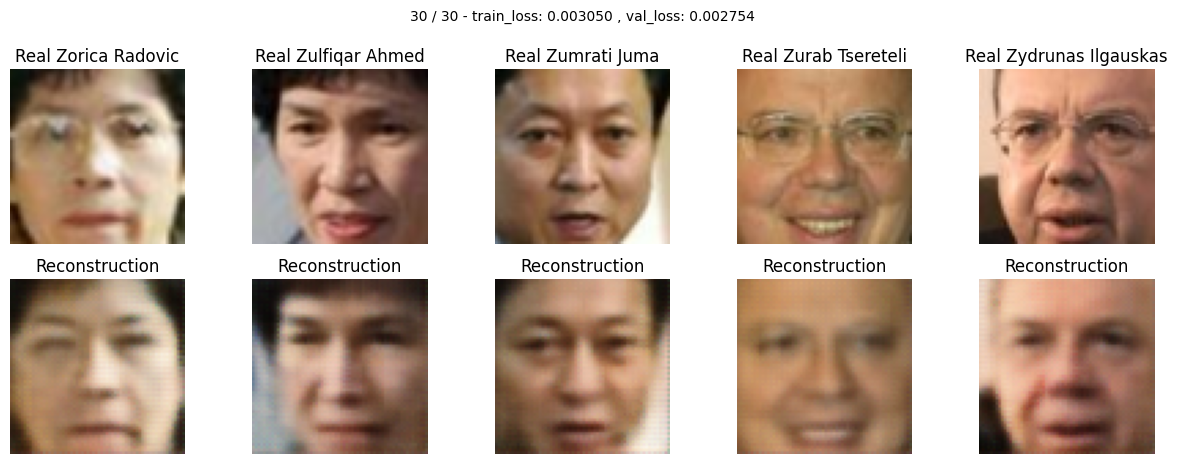

100%|██████████| 30/30 [01:40<00:00,  3.35s/it]


In [9]:
conv_autoencoder = ConvAutoencoder(dim_code=512).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(conv_autoencoder.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.95)

out, train_loss, val_loss = train(conv_autoencoder, optimizer, criterion, scheduler=scheduler, epochs=30)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

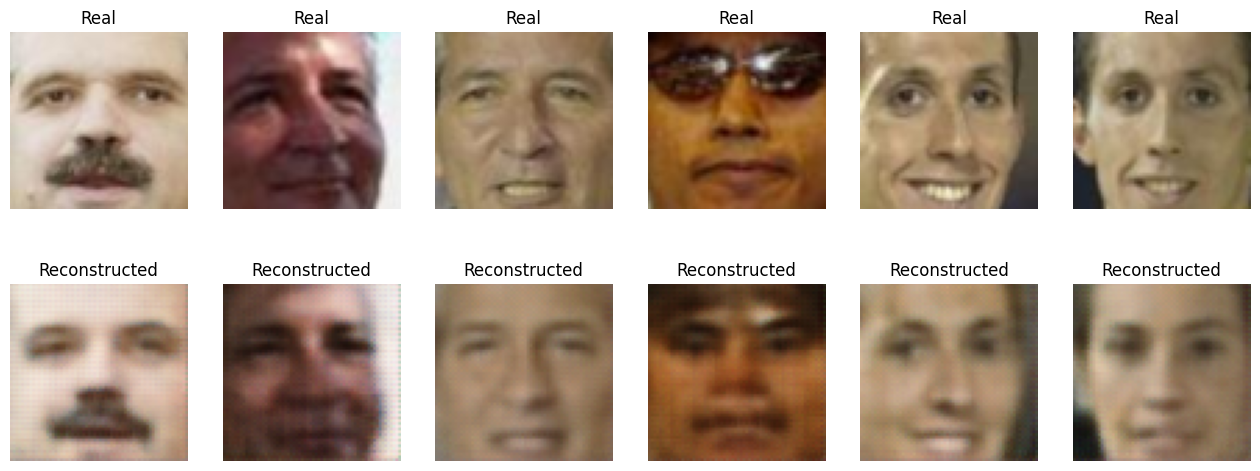

In [10]:
# indicies = np.random.choice(len(val_loader), 5, replace=False)
images = next(iter(val_loader))
conv_autoencoder.to(device)
conv_autoencoder.eval()
with torch.no_grad():
    reconstructed, _ = conv_autoencoder(images.to(device))

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        else:
            axes.imshow(reconstructed[j].cpu().permute(1,2,0))
            axes.set_title('Reconstructed')
        axes.axis('off')
plt.show()

Not bad, right?

In [11]:
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim=3*64*64, latent_dim=128):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, latent_dim),
            nn.Tanh() 
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, input_dim),
            nn.Unflatten(1, (3, 64, 64)),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

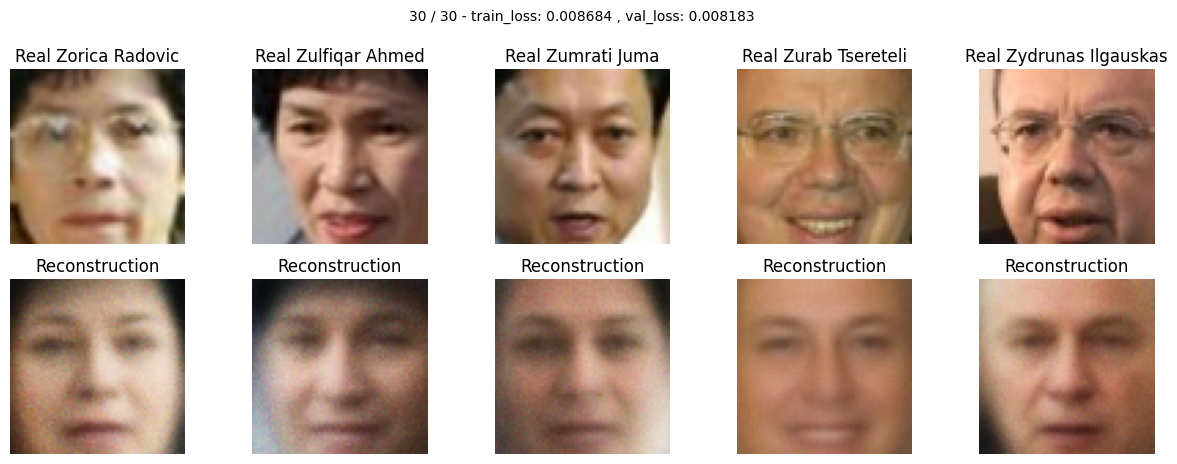

100%|██████████| 30/30 [02:11<00:00,  4.37s/it]


In [12]:
criterion = nn.MSELoss().to(device)

linear_autoencoder = LinearAutoencoder(latent_dim=512).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(linear_autoencoder.parameters(), lr=1e-4, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9)

lin_out, lin_train_loss, lin_val_loss = train(linear_autoencoder, optimizer, criterion, scheduler=scheduler, epochs=30)

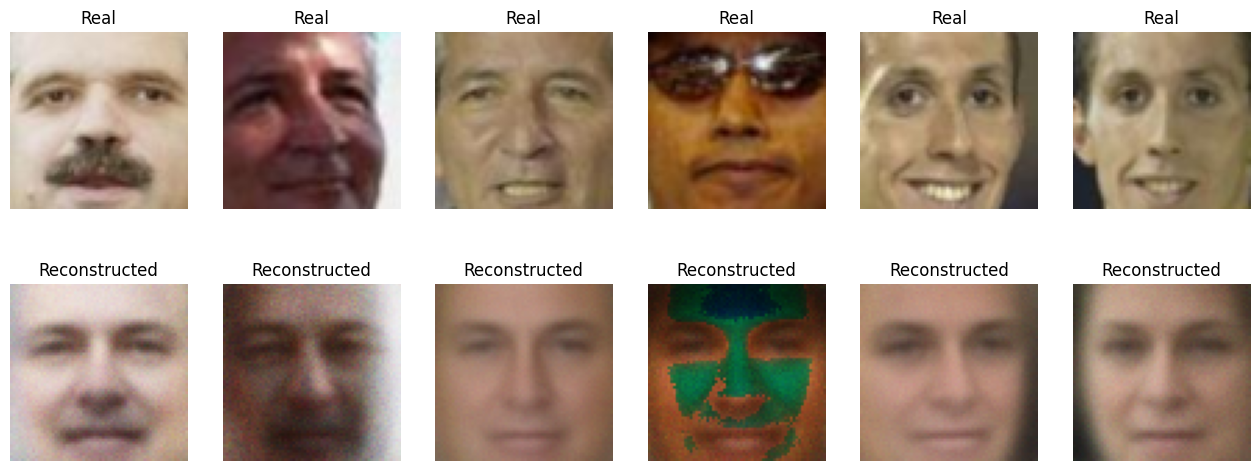

In [13]:
# indicies = np.random.choice(len(val_loader), 5, replace=False)
images = next(iter(val_loader))
linear_autoencoder.to(device)
linear_autoencoder.eval()
with torch.no_grad():
    reconstructed, _ = linear_autoencoder(images.to(device))

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        else:
            axes.imshow(reconstructed[j].cpu().permute(1,2,0))
            axes.set_title('Reconstructed')
        axes.axis('off')
plt.show()

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [14]:
all_vecs = torch.FloatTensor()
with torch.no_grad():
    conv_autoencoder.to(device)
    conv_autoencoder.eval()
    for batch in train_loader:
        batch = batch.to(device)
        latent = conv_autoencoder.encoder(batch)
        all_vecs = torch.cat((all_vecs,latent.cpu()))
        batch.cpu()
        del batch

latent_mean = all_vecs.mean(axis=0)
latent_std = all_vecs.std(axis=0)

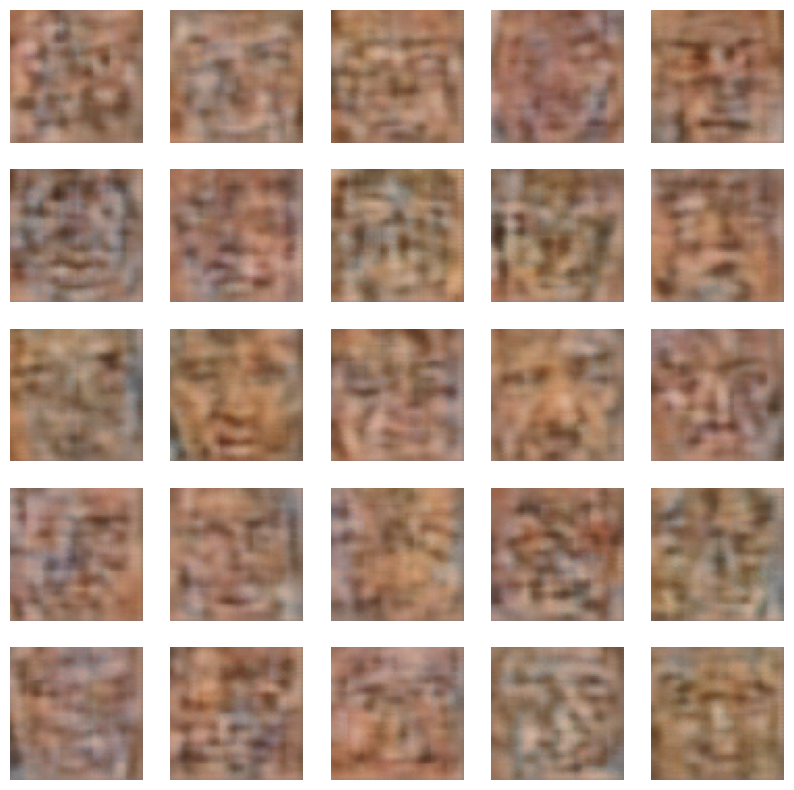

In [15]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 512)
output = conv_autoencoder.decoder(torch.Tensor(z).to(device))

plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = output[i].permute(1,2,0).cpu().detach().numpy()
    plt.imshow(generated)
    plt.axis('off')

plt.show()

It looks scary tbh. I can see distorted faces

In [16]:
latents = torch.Tensor()

conv_autoencoder.eval()
with torch.no_grad():
    for batch in train_loader:
        _, batch_latent = conv_autoencoder(batch.to(device))
        latents = torch.cat((latents, batch_latent.to("cpu")), dim=0)
        
mean, var = torch.mean(latents, axis=0), torch.std(latents, axis=0)

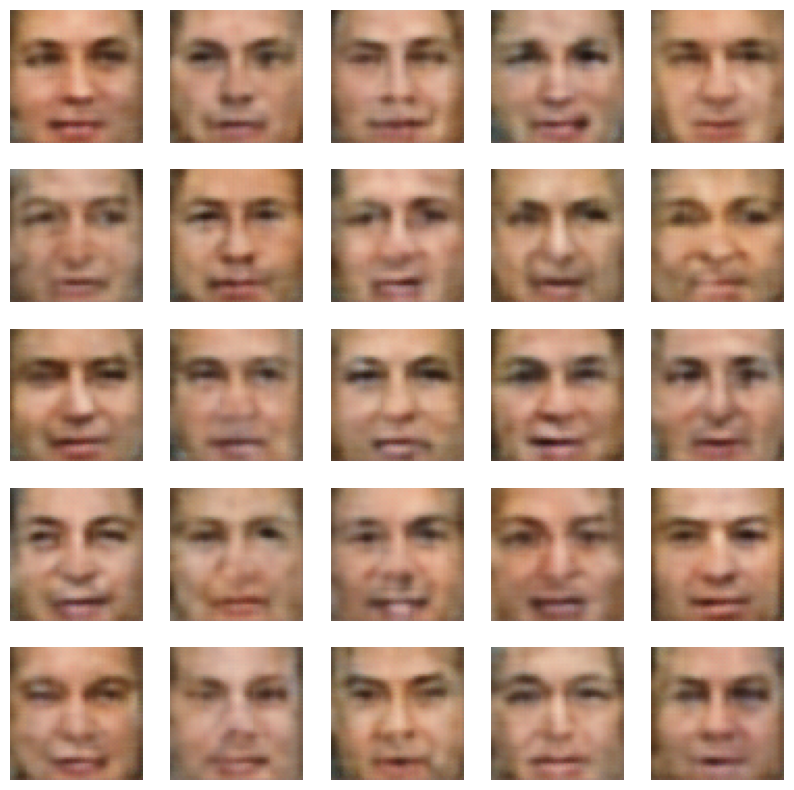

In [17]:
z = 0.15*var + torch.randn(25, 512) + 1.5*mean

output = conv_autoencoder.decoder(torch.Tensor(z).to(device))

plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = output[i].permute(1,2,0).cpu().detach().numpy()
    plt.imshow(generated)
    plt.axis('off')

plt.show()

Much better, but I had to find multipliers to make it look as it looks right now

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [18]:
attrs["Smiling"].astype(float).describe()

count    13143.000000
mean        -0.150700
std          1.127722
min         -2.686594
25%         -1.065725
50%         -0.320783
75%          0.766401
max          2.839994
Name: Smiling, dtype: float64

In [19]:
smily_idx = attrs.sort_values("Smiling", ascending=False).astype(float).dropna().head(30).index.to_numpy()
sad_idx = attrs.sort_values("Smiling", ascending=False).astype(float).dropna().tail(30).index.to_numpy()
smily_idx, sad_idx

(array([ 8643,  1816, 13034,  5624,  1045,  4681,  6139, 11797,  1359,
         2031,  1955,  9004,   459,  6166,   682,   983,  9165,  9005,
         1605, 12606, 12607,   135,  8247,  7941,  9755,   108, 12608,
         1533,   534,    88]),
 array([12992,  2647, 10491,  3935, 12272,  2000,  4392,  9201, 12298,
         2529,  6019,  2390,  8092,  3798,  6321,  9114, 10506, 10097,
         1432, 12688,  8596,  8410,   471,  1654, 11912,  7065,  5458,
         7506,  1234, 11571]))

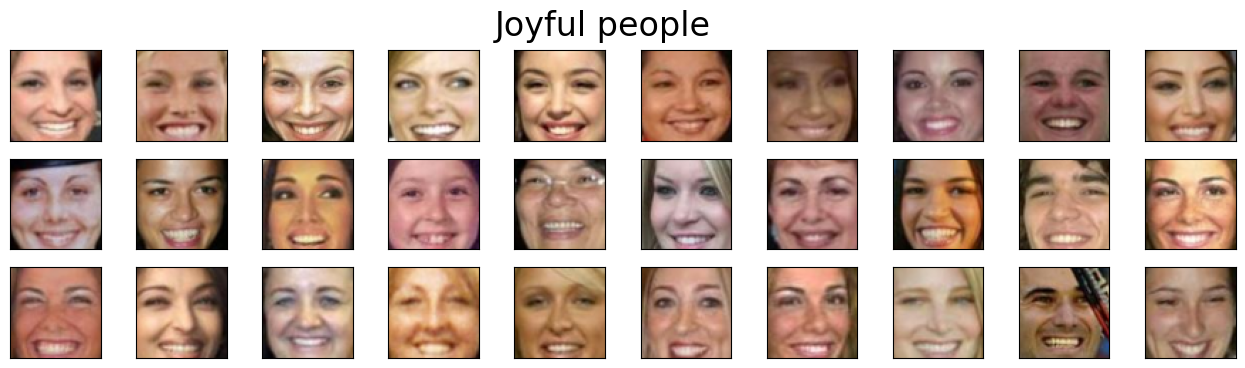

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(16, 4), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(data[smily_idx[count]])
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle('Joyful people', fontsize=24)
plt.show()

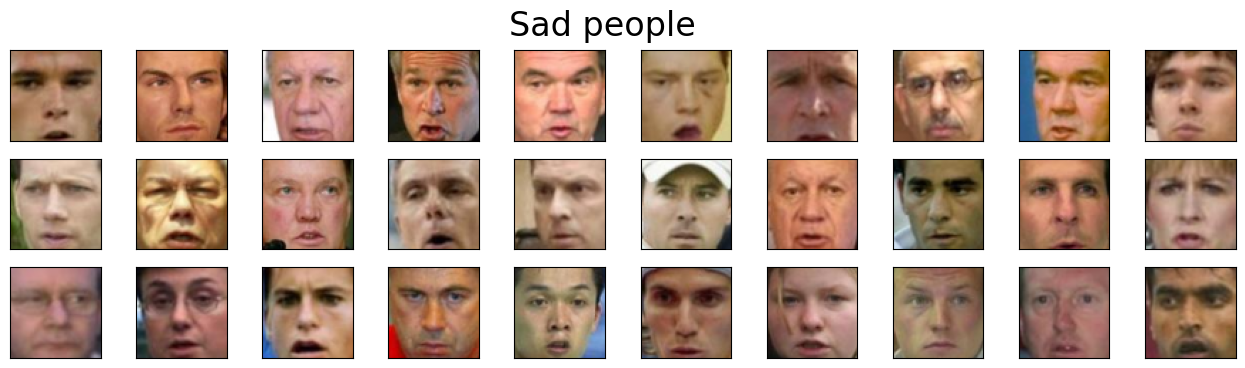

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(16, 4), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(data[sad_idx[count]])
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle('Sad people', fontsize=24)
plt.show()

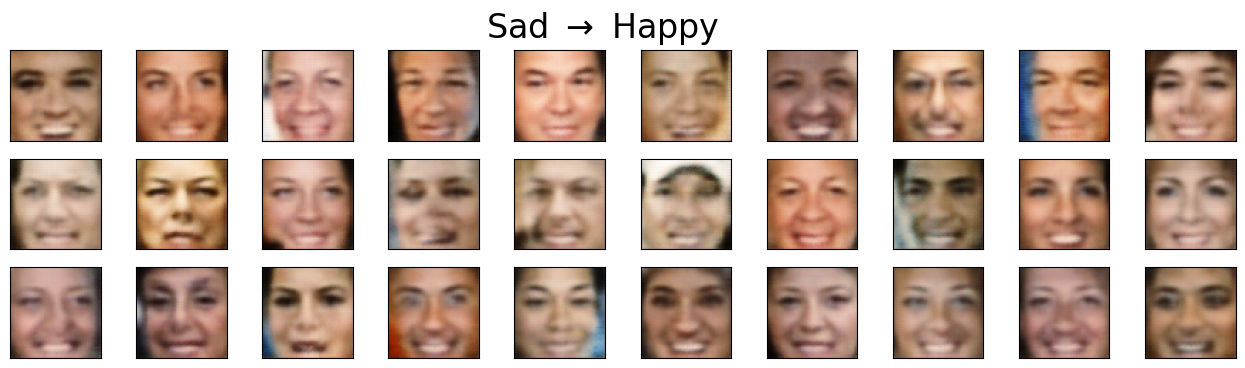

In [22]:
smile_latents = torch.FloatTensor().to(device)
sad_latents = torch.FloatTensor().to(device)

# Joyfullness vector calculation
for idx in smily_idx:
    smile_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        _, latent_smile = conv_autoencoder(smile_image)
    smile_latents = torch.cat((smile_latents, latent_smile))

# Calculation of sadness vector
for idx in sad_idx:
    sad_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        _, sad_latent = conv_autoencoder(sad_image)
    sad_latents = torch.cat((sad_latents, sad_latent))

# Define difference between joyful and sad 
smile = torch.mean(smile_latents, axis=0) - torch.mean(sad_latents, axis=0)

joyful_sad = sad_latents + smile

with torch.no_grad():
    output = conv_autoencoder.decoder(joyful_sad)

fig, ax = plt.subplots(3, 10, figsize=(16, 4), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(output[count].to("cpu").permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle(r'Sad $\rightarrow$ Happy', fontsize=24)
plt.show()

Вуаля! Вы восхитительны!

That's horrific

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [23]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15721821.08it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 468700.69it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4432132.95it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3448683.70it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [24]:
for image, classs in train_loader:
    print(image.shape)
    break

torch.Size([32, 1, 28, 28])


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [26]:
class VAE(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, vae_latent_size):
        super().__init__()
        self.out_channels = out_channels
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(.15),
            nn.Conv2d(out_channels, out_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(.15),
            nn.Conv2d(out_channels*2, out_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(out_channels*4),
            nn.LeakyReLU(.15),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(out_channels*4*4*4, vae_latent_size)
        self.fc_logsigma = nn.Linear(out_channels*4*4*4, vae_latent_size)
        
        self.decoder_input = nn.Linear(vae_latent_size, out_channels*4*4*4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(.15),
            nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(.15),
            nn.ConvTranspose2d(out_channels, in_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        """
        Реализуйте forward проход энкодера. В качестве ваозвращаемых переменных -- mu и logsigma
        """
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma
        

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            """
            Засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma
            """
            std = torch.exp(0.5*logsigma)
            return mu + std * torch.randn_like(std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        """
        Реализуйте forward проход декодер. В качестве возвращаемой переменной -- reconstruction
        """
        z = self.decoder_input(z)
        z = z.view(-1, self.out_channels*4, 4, 4)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        """
        Используя encode и decode, реализуйте forward проход автоэнкодера.
        В качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        """
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        
        return mu, logsigma, reconstruction

In [30]:
for elem in train_loader:
    print(elem[0].shape)
    break

torch.Size([32, 1, 28, 28])


In [37]:
in_channels = 1
out_channels = 32
vae_latent_size = 4
kernel_size = 3

summary(VAE(in_channels, out_channels, kernel_size, vae_latent_size).to(device), input_data=elem[0], batch_dim=0, device=device)

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 4]                    --
├─Sequential: 1-1                        [32, 2048]                --
│    └─Conv2d: 2-1                       [32, 32, 14, 14]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 14, 14]          64
│    └─LeakyReLU: 2-3                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 7, 7]            18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 7, 7]            128
│    └─LeakyReLU: 2-6                    [32, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 128, 4, 4]           73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 4, 4]           256
│    └─LeakyReLU: 2-9                    [32, 128, 4, 4]           --
│    └─Flatten: 2-10                     [32, 2048]                --
├─Linear: 1-2                            [32, 4]                   8,196
├

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [38]:
def KL_divergence(mu, logsigma):
    """
    Часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    Часть функции потерь, которая отвечает за качество реконструкции (как MSE в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction="sum")
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [39]:
def train_vae(model, optimizer, criterion, epochs=10, scheduler=None):
    
    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    outputs = []
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):

        model.train()  # train mode
        train_losses_per_epoch = []

        for data, _ in train_loader: # I dont need labels to recreate images
            image = data.to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(image)
            loss = criterion(image, mu, logsigma, reconstruction)
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for data, _ in test_loader:
                image = data.to(device)
                mu, logsigma, reconstruction = model(image)
                loss = criterion(image, mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        outputs.append((epoch, image, reconstruction),)

        # Save best model weights
        if val_losses[epoch] < best_loss_val:
            best_loss_val = val_losses[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualize tools
        clear_output(wait=True)

        fig = plt.figure(figsize=(12,6))
        fig.suptitle('%d / %d - train_loss: %f , val_loss: %f' % (epoch+1, epochs, np.mean(train_losses_per_epoch), np.mean(val_losses_per_epoch)),
                     y=1, fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        axis = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
        for k in range(10):
            if k < 5:
                axis[k].imshow(image[k].detach().cpu().permute(1,2,0))
                axis[k].set_title('Real ' + str(k+1))
                axis[k].grid(False)
                axis[k].axis('off')
            else:
                axis[k].imshow(reconstruction[k-5].detach().cpu().permute(1,2,0))#.squeeze(0))
                axis[k].set_title('Reconstruction '  + str((k+1) - 5))
                axis[k].grid(False)
                axis[k].axis('off')

        #plt.tight_layout()
        plt.show()

    # load best model weights
    model.load_state_dict(best_model_weights)

    return outputs, train_losses, val_losses

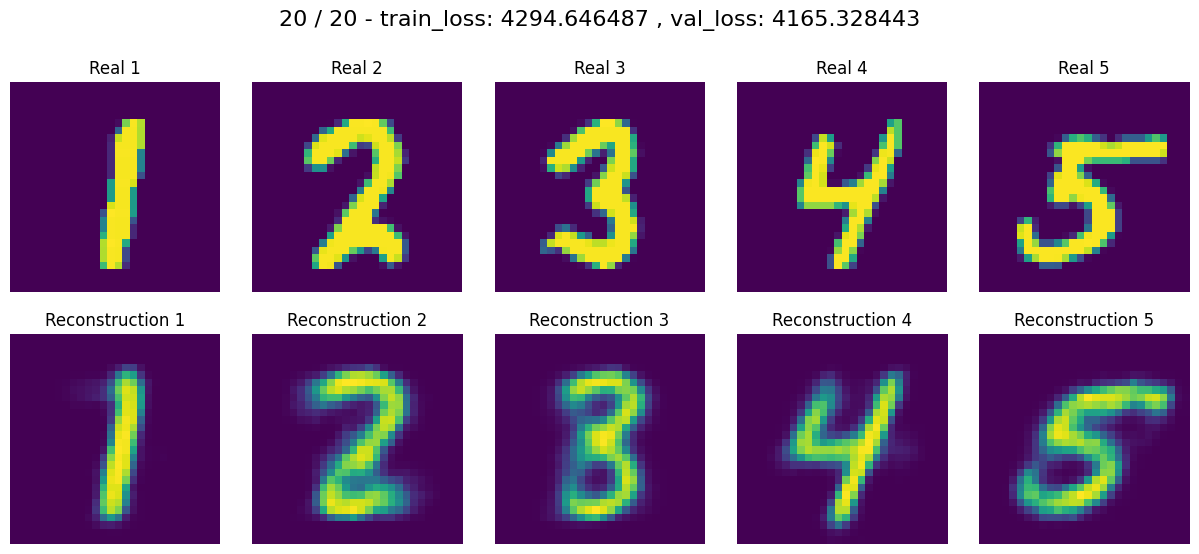

100%|██████████| 20/20 [06:11<00:00, 18.60s/it]


In [40]:
vae = VAE(in_channels, out_channels, kernel_size, vae_latent_size).to(device)

criterion = loss_vae
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.95)

out, train_loss, val_loss = train_vae(vae, optimizer, criterion, scheduler=scheduler, epochs=20)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

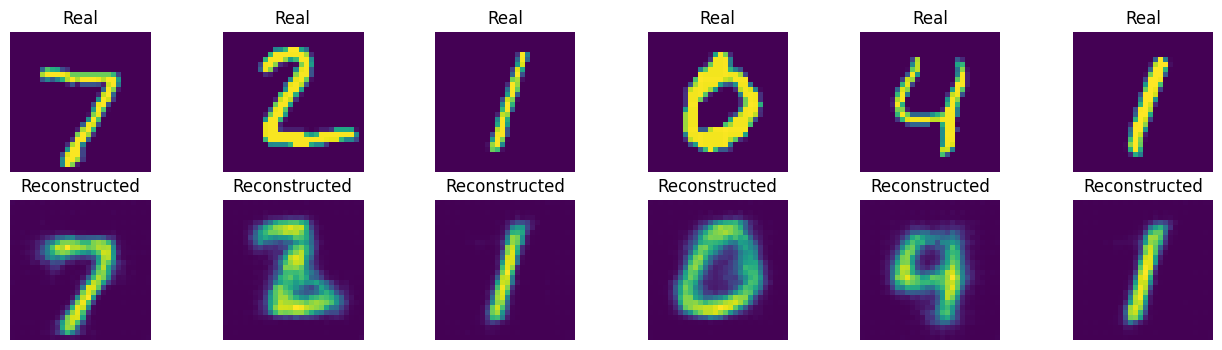

In [41]:
# indicies = np.random.choice(len(val_loader), 5, replace=False)
images = next(iter(test_loader))
conv_autoencoder.to(device)
conv_autoencoder.eval()
with torch.no_grad():
    _, _, reconstructed = conv_autoencoder(images[0].to(device))

fig, ax = plt.subplots(2, 6, figsize=(16, 4))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[0][j].permute(1,2,0), cmap="viridis")
            axes.set_title('Real')
        else:
            axes.imshow(reconstructed[j].cpu().permute(1,2,0), cmap="viridis")
            axes.set_title('Reconstructed')
        axes.axis('off')
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

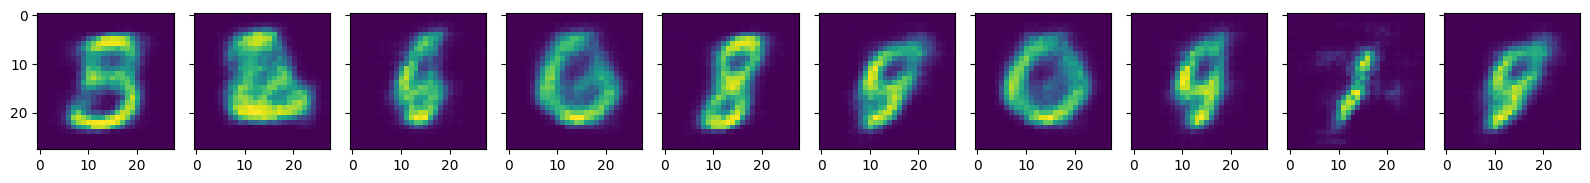

In [42]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, vae_latent_size) for i in range(10)])
conv_autoencoder.eval()
output = conv_autoencoder.decode(torch.Tensor(z).to(device))

fig, ax = plt.subplots(1, 10, sharey=True, figsize=(16, 3))
for i in range(10):
    ax[i].imshow(output[i].detach().cpu().permute(1,2,0))
    
plt.tight_layout()
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [43]:
labels = [_[1] for _ in test_dataset]
latents = torch.FloatTensor()

it = iter(test_loader)
conv_autoencoder.eval()
for i in range(len(test_loader)):
    img = next(it)[0].to(device)
    with torch.no_grad():
        latent = conv_autoencoder.gaussian_sampler(*conv_autoencoder.encode(img))
    latents = torch.cat([latents, latent.cpu()])

In [44]:
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style("darkgrid")

tsne_latents = TSNE(n_components=2, perplexity=20).fit_transform(latents)

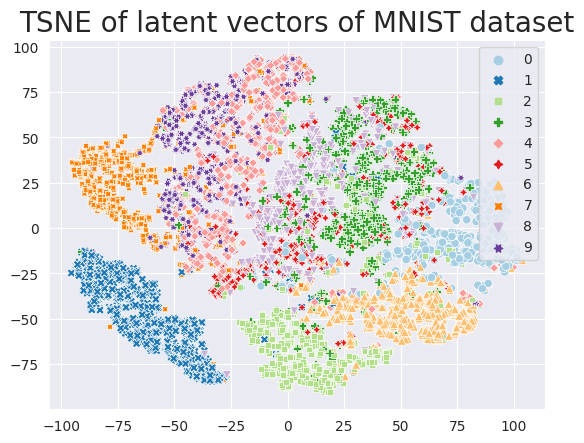

In [45]:
fig, ax = plt.subplots()
sns.scatterplot(x = tsne_latents[:, 0], y = tsne_latents[:, 1], hue=labels, palette='Paired', style=labels)
ax.set_title('TSNE of latent vectors of MNIST dataset', fontsize=20)
plt.show()

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [46]:
class CVAE(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, vae_latent_size, embedding_size):
        super().__init__()
        self.out_channels = out_channels
        self.embedding_size = embedding_size
        
        self.label_embedding = nn.Embedding(class_num, embedding_size)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(.15),
            nn.Conv2d(out_channels, out_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(.15),
            nn.Conv2d(out_channels*2, out_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(out_channels*4),
            nn.LeakyReLU(.15),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(out_channels*4*4*4 + embedding_size, vae_latent_size)
        self.fc_logsigma = nn.Linear(out_channels*4*4*4 + embedding_size, vae_latent_size)
        
        self.decoder_input = nn.Linear(vae_latent_size + embedding_size, out_channels*4*4*4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(out_channels*4, out_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(.15),
            nn.ConvTranspose2d(out_channels*2, out_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(.15),
            nn.ConvTranspose2d(out_channels, in_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        """
        Реализуйте forward проход энкодера. В качестве ваозвращаемых переменных -- mu и logsigma
        """        
        x = self.encoder(x)
        
        embedded_label = self.label_embedding(class_num).squeeze(1)
#         print(x.shape)
#         print(embedded_label.shape)
        x = torch.cat((x, embedded_label), dim=1)
        
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        return mu, logsigma
        

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            """
            Засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma
            """
            std = torch.exp(0.5*logsigma)
            return mu + std * torch.randn_like(std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        """
        Реализуйте forward проход декодер. В качестве возвращаемой переменной -- reconstruction
        """
        embedded_label = self.label_embedding(class_num).squeeze(1)
        z = torch.cat((z, embedded_label), dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, self.out_channels*4, 4, 4)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, labels):
        """
        Используя encode и decode, реализуйте forward проход автоэнкодера.
        В качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        """
        mu, logsigma = self.encode(x, labels.long())
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, labels.long())
        
        return mu, logsigma, reconstruction

In [47]:
for batch in train_loader:
    image, label = batch
    print(f"{image.shape=}")
    print(f"{label.shape=}")
    break
    
class_num = 10
summary(CVAE(in_channels, out_channels, kernel_size, vae_latent_size, embedding_size=28).to(device), input_data = [image, label], batch_dim = 0, device="cuda")

image.shape=torch.Size([32, 1, 28, 28])
label.shape=torch.Size([32])


Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [1, 4]                    --
├─Sequential: 1-1                        [32, 2048]                --
│    └─Conv2d: 2-1                       [32, 32, 14, 14]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 14, 14]          64
│    └─LeakyReLU: 2-3                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 7, 7]            18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 7, 7]            128
│    └─LeakyReLU: 2-6                    [32, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 128, 4, 4]           73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 4, 4]           256
│    └─LeakyReLU: 2-9                    [32, 128, 4, 4]           --
│    └─Flatten: 2-10                     [32, 2048]                --
├─Embedding: 1-2                         [32, 28]                  280
├─L

In [48]:
def train_cvae(model, optimizer, criterion, epochs=10, scheduler=None):
    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    outputs = []
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):
        model.train()  # train mode
        train_losses_per_epoch = []

        for data, labels in train_loader:
            image = data.to(device)
            labels = labels.to(device)  # Move labels to the same device

            # set parameter gradients to zero
            optimizer.zero_grad()

            # Pass labels to the model
            mu, logsigma, reconstruction = model(image, labels)

            loss = criterion(image, mu, logsigma, reconstruction)
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for data, labels in test_loader:
                image = data.to(device)
                labels = labels.to(device)  # Move labels to the same device

                # Pass labels to the model
                mu, logsigma, reconstruction = model(image, labels)

                loss = criterion(image, mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        outputs.append((epoch, image, reconstruction),)

        # Save best model weights
        if val_losses[epoch] < best_loss_val:
            best_loss_val = val_losses[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualize tools
        clear_output(wait=True)

        fig = plt.figure(figsize=(12, 6))
        fig.suptitle("%d / %d - train_loss: %f , val_loss: %f" % (
                epoch + 1,
                epochs,
                np.mean(train_losses_per_epoch),
                np.mean(val_losses_per_epoch),),
            y=1, fontsize=16,
        )

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        axis = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
        for k in range(10):
            if k < 5:
                axis[k].imshow(image[k].detach().cpu().permute(1, 2, 0))
                axis[k].set_title("Real " + str(k + 1))
                axis[k].grid(False)
                axis[k].axis("off")
            else:
                axis[k].imshow(
                    reconstruction[k - 5].detach().cpu().permute(1, 2, 0)
                )  # .squeeze(0))
                axis[k].set_title("Reconstruction " + str((k+1)%5))
                axis[k].grid(False)
                axis[k].axis("off")
                
        plt.show()
        
    return outputs, train_losses, val_losses

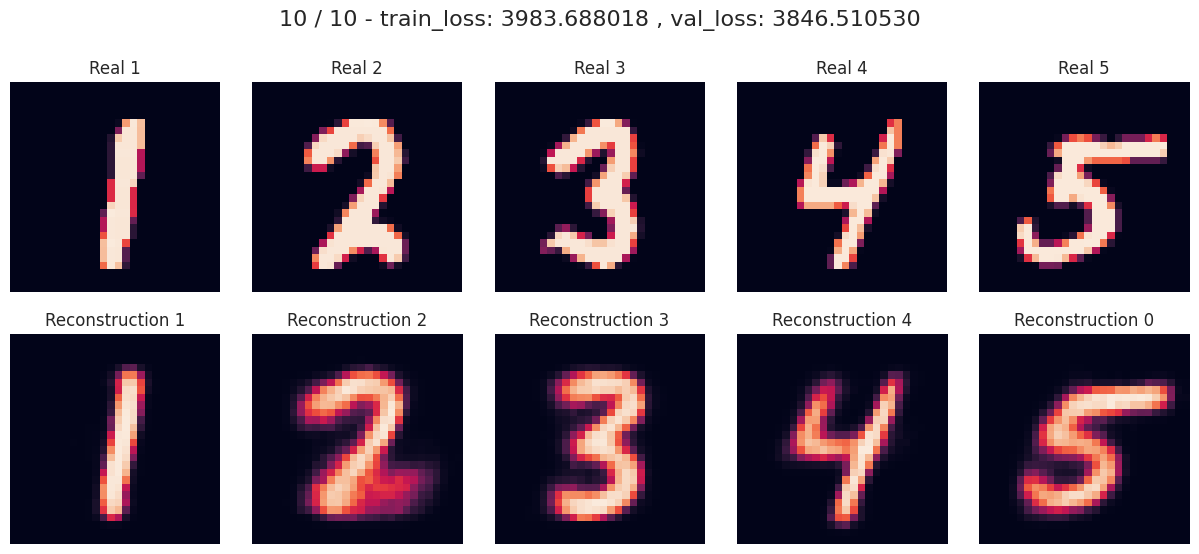

100%|██████████| 10/10 [03:18<00:00, 19.81s/it]


In [49]:
cvae = CVAE(in_channels, out_channels, kernel_size, vae_latent_size, embedding_size=64).to(device)

criterion = loss_vae
optimizer = torch.optim.AdamW(cvae.parameters(), lr=3e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9)

out, train_loss, val_loss = train_cvae(cvae, optimizer, criterion, scheduler=scheduler, epochs=10)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

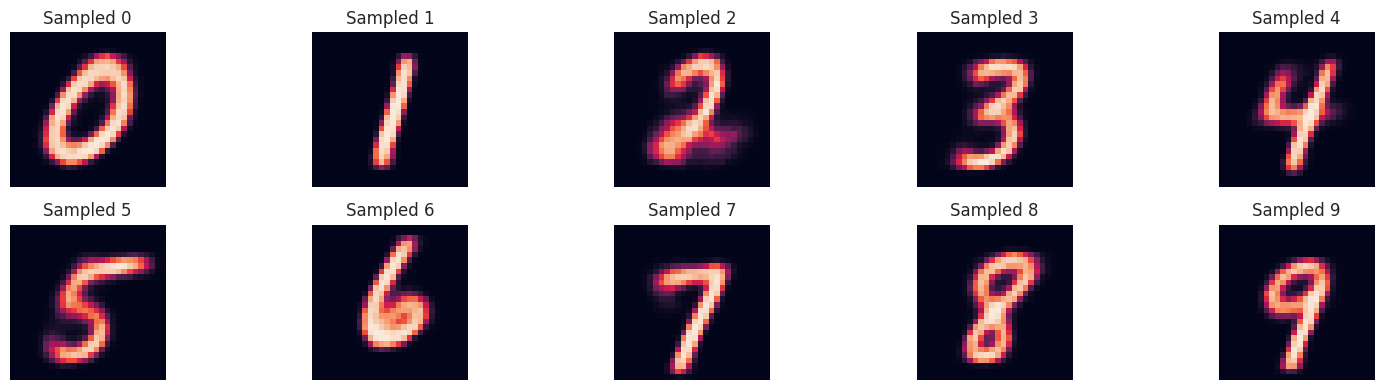

In [50]:
z = torch.randn(1, vae_latent_size)
z = torch.tile(z, dims=(10, 1))
labels = torch.LongTensor(list(range(10)))
cvae.eval()
with torch.no_grad():
    output = cvae.decode(z.to(device), labels.to(device))
fig, ax = plt.subplots(2, 5, figsize=(16, 4))
for i in range(2):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().permute(1,2,0))
        axes.set_title(f'Sampled {5*i+j}')
        axes.axis('off')
plt.tight_layout()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [51]:
labels = [_[1] for _ in test_dataset]
latents = torch.FloatTensor()

it = iter(test_loader)
conv_autoencoder.eval()
for i in range(len(test_loader)):
    elem = next(it)
    img = elem[0].to(device)
    label = elem[1].to(device)
    with torch.no_grad():
        latent = cvae.gaussian_sampler(*cvae.encode(img, label))
    latents = torch.cat([latents, latent.cpu()])

In [52]:
tsne_latents = TSNE(n_components=2).fit_transform(latents)

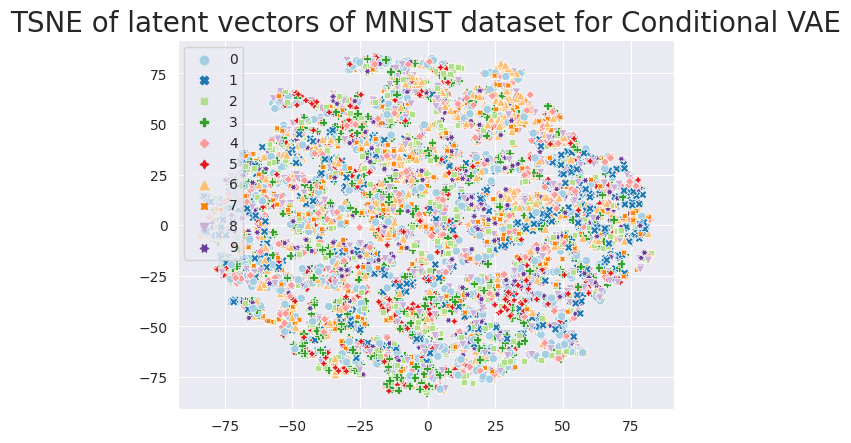

In [53]:
fig, ax = plt.subplots()
sns.scatterplot(x = tsne_latents[:, 0], y = tsne_latents[:, 1], hue=labels, palette='Paired', style=labels)
ax.set_title('TSNE of latent vectors of MNIST dataset for Conditional VAE', fontsize=20)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Yes, this distribution of dataset objects is very different from what is seen in the distribution of elements for the classic VAE. Here, given the large mixing and the complete absence of any clusters, it is clear that the images were combined according to other signs. I will assume that these were some outlines, but not the "structural elements" of the figure.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

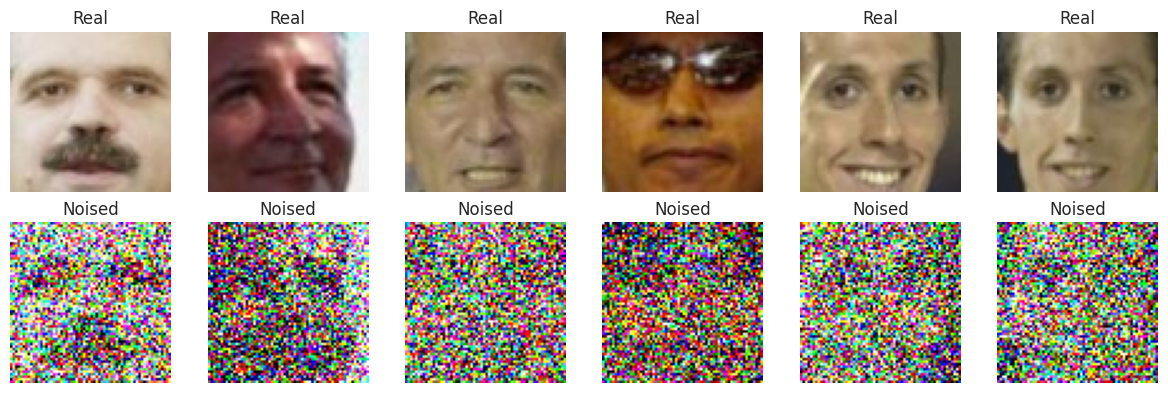

In [54]:
def RandomNoise(img):
    noise_factor = .8
    img_noisy = img + noise_factor * torch.normal(mean=0, std=1, size=img.shape) 
    return torch.clip(img_noisy, 0, 1)

images = next(iter(val_loader))
noise_images = RandomNoise(copy.deepcopy(images)).to('cpu')

fig, ax = plt.subplots(2, 6, figsize=(12, 4))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        else:
            axes.imshow(noise_images[j].permute(1,2,0))
            axes.set_title('Noised')
        axes.axis('off')
plt.tight_layout()
plt.show()

In [55]:
def noise_train(model, optimizer, criterion, epochs=10, scheduler=None):
    
    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    outputs = []
    train_losses = []
    val_losses = []
    person = file_attrs['person'].tail(5).values.tolist()

    for epoch in tqdm(range(epochs)):

        model.train()  # train mode
        train_losses_per_epoch = []

        for data in train_loader:
#             print(data.shape)
            noisy_image = RandomNoise(copy.deepcopy(data)).to(device)
            image = data.to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()
            reconstruction, _ = model(noisy_image)
            loss = criterion(reconstruction, image) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for data in val_loader:
                noisy_image = RandomNoise(copy.deepcopy(data)).to(device)
                image = data.to(device)
                reconstruction, _ = model(noisy_image)
                loss = criterion(reconstruction, image)
                val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        outputs.append((epoch, image, reconstruction),)

        # Save best model weights
        if val_losses[epoch] < best_loss_val:
            best_loss_val = val_losses[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualize tools
        clear_output(wait=True)

        fig = plt.figure(figsize=(15,6))
        fig.suptitle('%d / %d - train_loss: %f , val_loss: %f' % (epoch+1, epochs, np.mean(train_losses_per_epoch), np.mean(val_losses_per_epoch)),
                     y=1, fontsize=10)

        gs1  = GridSpec(3, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1  = fig.add_subplot(gs1[0, :1])
        ax2  = fig.add_subplot(gs1[0, 1])
        ax3  = fig.add_subplot(gs1[0, 2])
        ax4  = fig.add_subplot(gs1[0, 3])
        ax5  = fig.add_subplot(gs1[0, 4])

        ax6  = fig.add_subplot(gs1[1, :1])
        ax7  = fig.add_subplot(gs1[1, 1])
        ax8  = fig.add_subplot(gs1[1, 2])
        ax9  = fig.add_subplot(gs1[1, 3])
        ax10 = fig.add_subplot(gs1[1, 4])
        
        ax11 = fig.add_subplot(gs1[2, :1])
        ax12 = fig.add_subplot(gs1[2, 1])
        ax13 = fig.add_subplot(gs1[2, 2])
        ax14 = fig.add_subplot(gs1[2, 3])
        ax15 = fig.add_subplot(gs1[2, 4])

        axis = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]
        for k in range(15):
            if k < 5:
                axis[k].imshow(image[k].detach().cpu().permute(1,2,0))
                axis[k].set_title('Real / ' + person[k])
                axis[k].grid(False)
                axis[k].axis('off')
            elif 5 <= k < 10:
                axis[k].imshow(noisy_image[k].detach().cpu().permute(1,2,0))
                axis[k].set_title('Real Noisy ' + person[k-5])
                axis[k].grid(False)
                axis[k].axis('off')
            else:
                axis[k].imshow(reconstruction[k-10].detach().cpu().permute(1,2,0))
                axis[k].set_title('Reconstruction')
                axis[k].grid(False)
                axis[k].axis('off')

        plt.show()

    # load best model weights
    model.load_state_dict(best_model_weights)

    return outputs, train_losses, val_losses

In [56]:
BATCH_SIZE = 128

train_photos_t = torch.FloatTensor(train_photos).permute(0,3,1,2) # numpy.ndarray to tensor_float32 [32, 128, 128, 3] --> [32, 3, 128, 128]
val_photos_t = torch.FloatTensor(val_photos).permute(0,3,1,2) # numpy.ndarray to tensor_float32 [32, 128, 128, 3] --> [32, 3, 128, 128]

train_loader = torch.utils.data.DataLoader(train_photos_t, batch_size=BATCH_SIZE, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_photos_t, batch_size=BATCH_SIZE, num_workers=4)

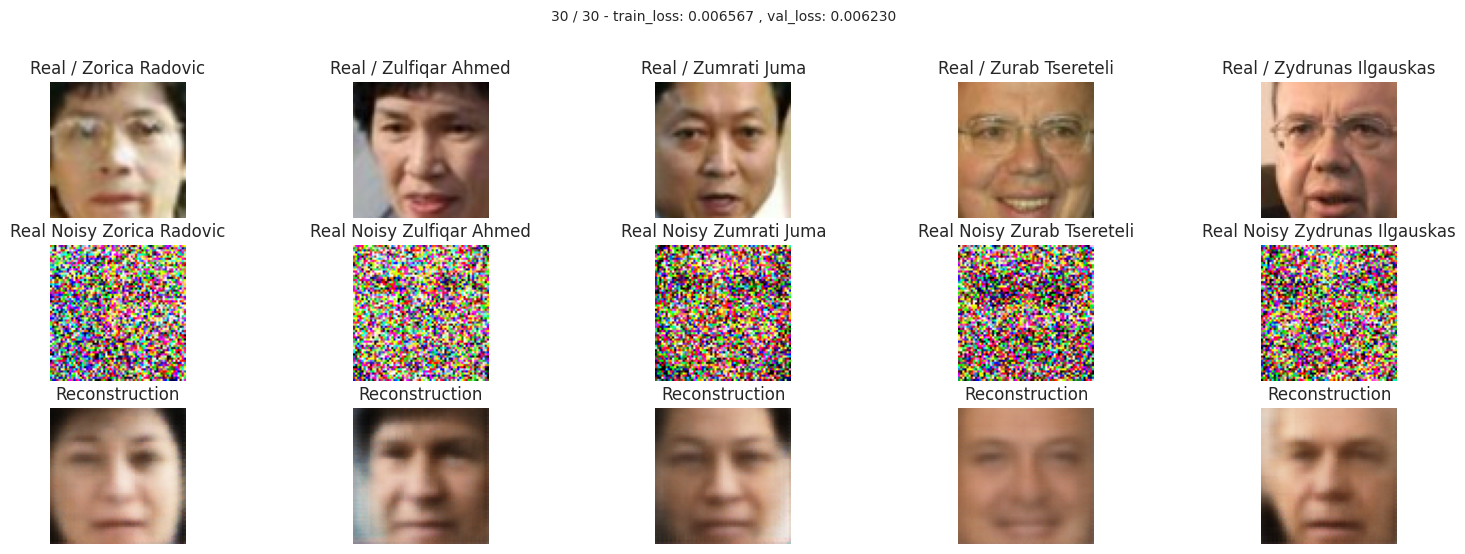

100%|██████████| 30/30 [03:22<00:00,  6.74s/it]


In [57]:
noise_conv_autoencoder = ConvAutoencoder(dim_code=512).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(noise_conv_autoencoder.parameters(), lr=1e-3, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9)

out, train_loss, val_loss = noise_train(noise_conv_autoencoder, optimizer, criterion, scheduler=scheduler, epochs=30)

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

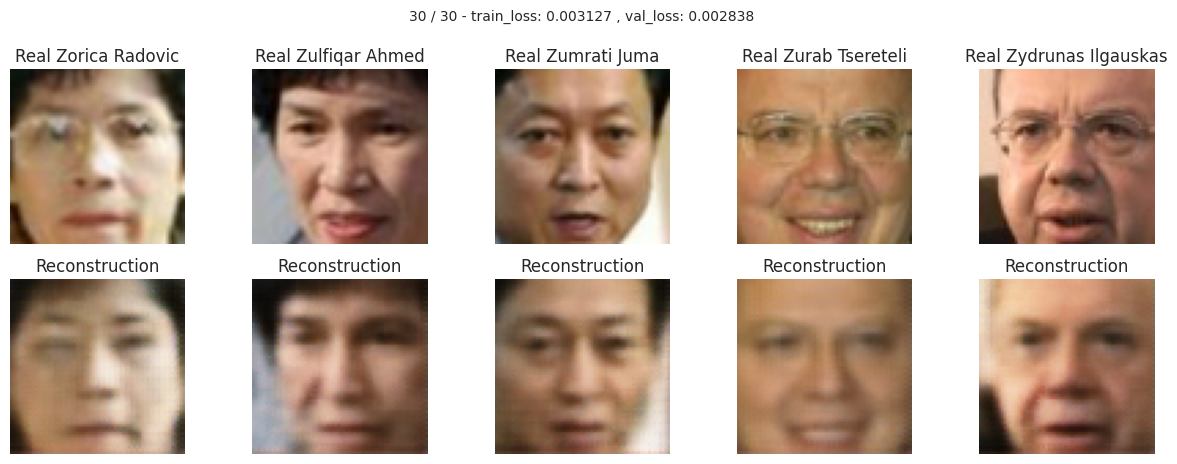

100%|██████████| 30/30 [02:07<00:00,  4.25s/it]


In [58]:
conv_autoencoder = ConvAutoencoder(dim_code=512).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(conv_autoencoder.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.95)

out, train_loss, val_loss = train(conv_autoencoder, optimizer, criterion, scheduler=scheduler, epochs=30)

In [59]:
latents = torch.FloatTensor()
iterator = iter(train_loader)
conv_autoencoder.to(device)
for i in range(len(train_loader)):
    images = next(iterator)
    conv_autoencoder.eval()
    with torch.no_grad():
        _, latent = conv_autoencoder(images.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [60]:
# обучаем LSHForest, которого больше не существует, ага.
from sklearn.neighbors import NearestNeighbors
lshf = NearestNeighbors(n_neighbors=50).fit(latents)

In [61]:
def get_similar(model, image, n_neighbors=5):
    """
    Функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы.
    Прогоняет векторы через декодер и получает картинки ближайших людей
    """
    model.eval()
    with torch.no_grad():
        _, code = model(image.unsqueeze(0).to(device))

    distances, num_latents = lshf.kneighbors(code.cpu(), n_neighbors=n_neighbors)
    n_latents = torch.FloatTensor() 
    
    for i in num_latents:
        n_latents = torch.cat((n_latents, latents[i].cpu()))
            
    return distances, n_latents, num_latents

In [62]:
def show_similar(model, image):
    """
    Функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    """

    distances, n_latents, num_latents = get_similar(model, image, n_neighbors=11)

    plt.figure(figsize=(12, 9))
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Original image of {file_attrs['person'][k]}")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(train_photos_t[num_latents[0][i]].cpu().numpy().transpose([1,2,0]))
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{file_attrs['person'].iloc[num_latents[0][i]]}, \n Distance={round(distances[0][i])}")
    plt.show()

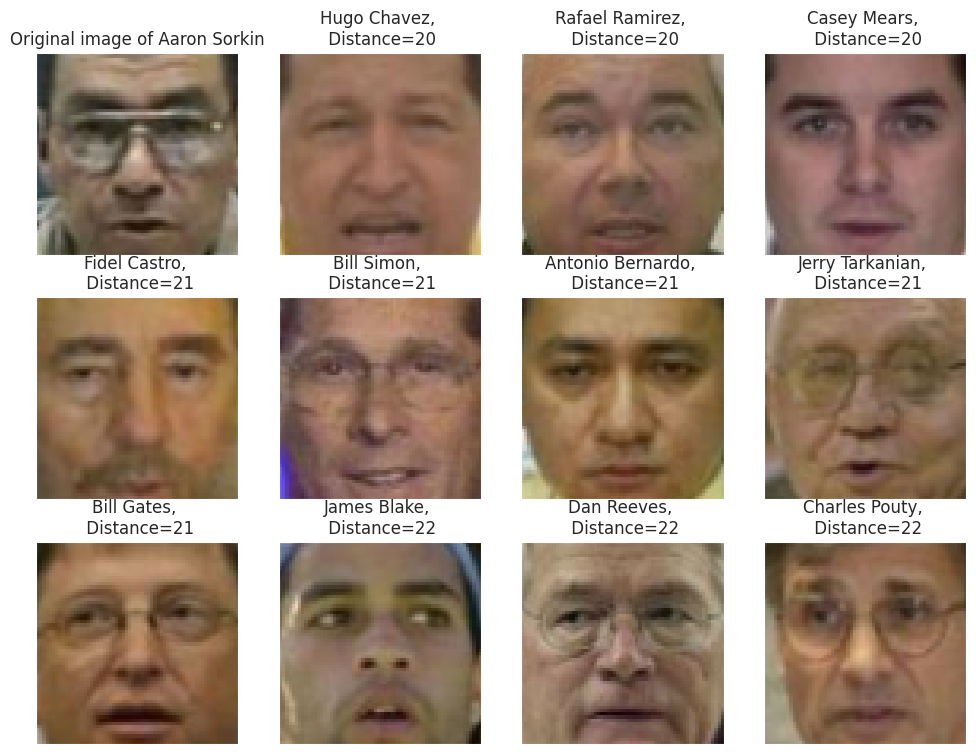

In [63]:
k = 8
img = next(iter(val_loader))[k]
show_similar(conv_autoencoder, img)